In [12]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data7/")

In [4]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [5]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data7/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
6619,/home/pascal_steiger/Downloads/data7/CHE/img_4...,CHE
1238,/home/pascal_steiger/Downloads/data7/ISL/img_I...,ISL
3282,/home/pascal_steiger/Downloads/data7/GBR/img_5...,GBR
4589,/home/pascal_steiger/Downloads/data7/FIN/img_F...,FIN
6621,/home/pascal_steiger/Downloads/data7/CHE/img_4...,CHE
6754,/home/pascal_steiger/Downloads/data7/CHE/img_4...,CHE
2439,/home/pascal_steiger/Downloads/data7/ITA/img_I...,ITA
5214,/home/pascal_steiger/Downloads/data7/PRT/img_P...,PRT
2768,/home/pascal_steiger/Downloads/data7/ITA/img_I...,ITA
4628,/home/pascal_steiger/Downloads/data7/FIN/img_F...,FIN


In [6]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                   path label
659   /home/pascal_steiger/Downloads/data7/MKD/img_M...   MKD
3965  /home/pascal_steiger/Downloads/data7/GBR/img_5...   GBR
2947  /home/pascal_steiger/Downloads/data7/ITA/img_I...   ITA
2864  /home/pascal_steiger/Downloads/data7/ITA/img_I...   ITA
3239  /home/pascal_steiger/Downloads/data7/GBR/img_5...   GBR
(5611, 2)
                                                   path label
3458  /home/pascal_steiger/Downloads/data7/GBR/img_5...   GBR
1480  /home/pascal_steiger/Downloads/data7/ISL/img_I...   ISL
5244  /home/pascal_steiger/Downloads/data7/PRT/img_P...   PRT
2594  /home/pascal_steiger/Downloads/data7/ITA/img_I...   ITA
6737  /home/pascal_steiger/Downloads/data7/CHE/img_4...   CHE
(1403, 2)


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        seed=42
)

Found 5611 validated image filenames belonging to 7 classes.
Found 1403 validated image filenames belonging to 7 classes.


In [10]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    tl_incep = InceptionV3(include_top=True,weights=None)
    tl_incep = tf.keras.Model(tl_incep.input, tl_incep.layers[-2].output)
    for layer in tl_incep.layers:
        layer.trainable = True
    print(tl_incep.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
    I = Input(shape=(299, 299, 3))



    x = tl_incep(I)
    
    dense = Dense(1024, activation='relu', name='denserelu')(x)
    
    dropout = Dropout(0.2)(dense)

    dense3 = Dense(26, activation='softmax', name='my_dense')(dropout)
    
    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
my_dense (Dense)             (None, 26)                26650     
Total params: 23,927,610
Trainable params: 23,893,178
Non-trainable params: 34,432
_________________________________________________________________


In [15]:
def unwrap_model(model):
    mdl = model.get_layer('model')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [16]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [19]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [21]:

with tf.device("/device:GPU:1"):
    history = new_model2.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=200,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks = callbacks)

Epoch 1/200
176/176 [==============================] - 312s 2s/step - loss: 1.8183 - sparse_categorical_accuracy: 0.3242 - val_loss: 3.5391 - val_sparse_categorical_accuracy: 0.1523
Epoch 2/200
176/176 [==============================] - 144s 817ms/step - loss: 1.4779 - sparse_categorical_accuracy: 0.4463 - val_loss: 2.9572 - val_sparse_categorical_accuracy: 0.1758
Epoch 3/200
176/176 [==============================] - 144s 813ms/step - loss: 1.3566 - sparse_categorical_accuracy: 0.4864 - val_loss: 1.3630 - val_sparse_categorical_accuracy: 0.5156
Epoch 4/200
176/176 [==============================] - 142s 807ms/step - loss: 1.2733 - sparse_categorical_accuracy: 0.5138 - val_loss: 2.3728 - val_sparse_categorical_accuracy: 0.4141
Epoch 5/200
176/176 [==============================] - 141s 799ms/step - loss: 1.2250 - sparse_categorical_accuracy: 0.5397 - val_loss: 2.1494 - val_sparse_categorical_accuracy: 0.3164
Epoch 6/200
176/176 [==============================] - 138s 782ms/step - loss:

176/176 [==============================] - 137s 774ms/step - loss: 0.2893 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.8553 - val_sparse_categorical_accuracy: 0.7461
Epoch 45/200
176/176 [==============================] - 138s 785ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 0.7852
Epoch 46/200
176/176 [==============================] - 138s 783ms/step - loss: 0.2644 - sparse_categorical_accuracy: 0.9054 - val_loss: 0.9794 - val_sparse_categorical_accuracy: 0.7500
Epoch 47/200
176/176 [==============================] - 135s 764ms/step - loss: 0.2515 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.7800 - val_sparse_categorical_accuracy: 0.7773
Epoch 48/200
176/176 [==============================] - 136s 771ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.7656
Epoch 49/200
176/176 [==============================] - 137s 777ms/step - loss: 0.2

In [23]:
with tf.device("/device:GPU:1"):
    new_model2.save('CNN_v3_fullNet.h5')

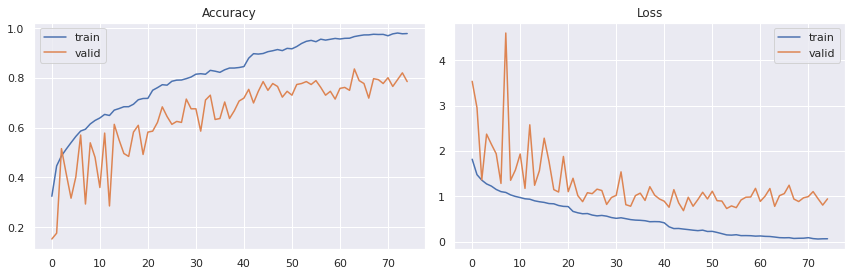

In [24]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(299,299)_v3.png')

plt.show()

In [87]:
def make_prediction(path, model, size=(250,250)):
    d = {'path': [path], 'label': [os.path.dirname(path)]}
    df = pd.DataFrame(data=d)
    pred_gen = ImageDataGenerator(rescale=1./255)
    pred_generator = pred_gen.flow_from_dataframe(
        dataframe=df,
        x_col="path",
        y_col="label",
        target_size=size,
        batch_size=1,
        shuffle=False,
        class_mode="sparse",
        seed=42
    )
    res = model.predict(pred_generator)
    return (labelStringArr[np.argmax(res)], res[0][np.argmax(res)])
    

In [88]:
make_prediction("/mnt/data/data/POL/img_POL_50.114902597259785,21.71049290647834_180.jpg", model)

Found 1 validated image filenames belonging to 1 classes.


('DNK', 0.11289916)

<AxesSubplot:xlabel='label', ylabel='count'>

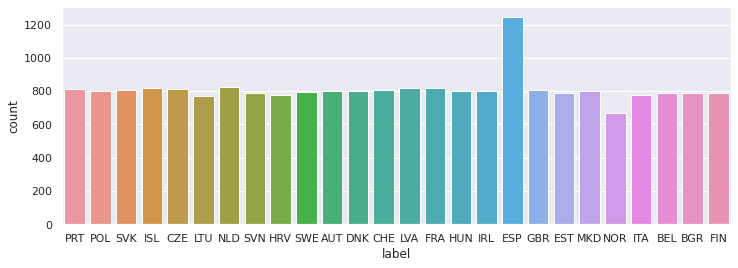

In [91]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.countplot(x='label', data=train_df)

In [94]:
print("on valid data")
pred1=model.evaluate(X_valid,Y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))


KeyError: 1

<Figure size 432x432 with 0 Axes>